In [1]:
import sys

import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
import mne

sys.path.append("..")
from util.plot import Background

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
filename = "../data/Recordings/id038/rec_0002.npz"
contact = "TB'6"

taa_interval = (265, 298)

In [3]:
data = np.load(filename)

t_onset = data['onset']
t_term = data['termination']
duration = t_term - t_onset
sz_interval = (t_onset - 0.2 * duration, t_term + 0.2 * duration)

ind = list(data['names']).index(contact)
t = data['t']
x = data['seeg'][ind]

In [4]:
fs = 1./(t[1] - t[0])
freqs = np.linspace(1, 64, 128)
tfr = mne.time_frequency.tfr_array_multitaper(x[None, None, :],
                                              fs, freqs,
                                              # time_bandwidth=4.0, n_cycles=8,
                                              time_bandwidth=2.0, n_cycles=freqs,
                                              zero_mean=False, output='avg_power', n_jobs=6)[0]


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    3.5s finished


In [5]:
from matplotlib.patches import Rectangle
import itertools

def scale_bars(ax, pos, sizex=None, labelx=None, sizey=None, labely=None, barwidth=4, fontsize=14):
    if sizex:
        sizex_ax = ax.transLimits.transform((sizex, 0))[0] - ax.transLimits.transform((0, 0))[0]
        ax.add_artist(Rectangle(pos, sizex_ax, 0, lw=barwidth, ec='black', transform=ax.transAxes))
        if labelx:
            ax.annotate(labelx, xy=(pos[0] + 0.5*sizex_ax, pos[1]), xycoords='axes fraction',
                        xytext=(0, -0.5*fontsize), textcoords='offset points', ha='center', va='top',
                        fontsize=fontsize)
            
    if sizey:
        sizey_ax = ax.transLimits.transform((0, sizey))[1] - ax.transLimits.transform((0, 0))[1]
        ax.add_artist(Rectangle(pos, 0, sizey_ax, lw=barwidth, ec='black', transform=ax.transAxes))
        if labely:
            ax.annotate(labely, xy=(pos[0], pos[1] + 0.5*sizey_ax), xycoords='axes fraction',
                        xytext=(-0.5*fontsize, 0), textcoords='offset points', ha='right', va='center',
                        fontsize=fontsize)
            

def add_panel_letters(fig, axes=None, fontsize=30, xpos=-0.04, ypos=1.05):
    labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    if axes is None:
        axes = fig.get_axes()

    if type(xpos) == float:
        xpos = itertools.repeat(xpos)
    if type(ypos) == float:
        ypos = itertools.repeat(ypos)

    for i, (ax, x, y) in enumerate(zip(axes, xpos, ypos)):
        ax.text(x, y, labels[i],
                transform=ax.transAxes, size=fontsize, weight='bold')

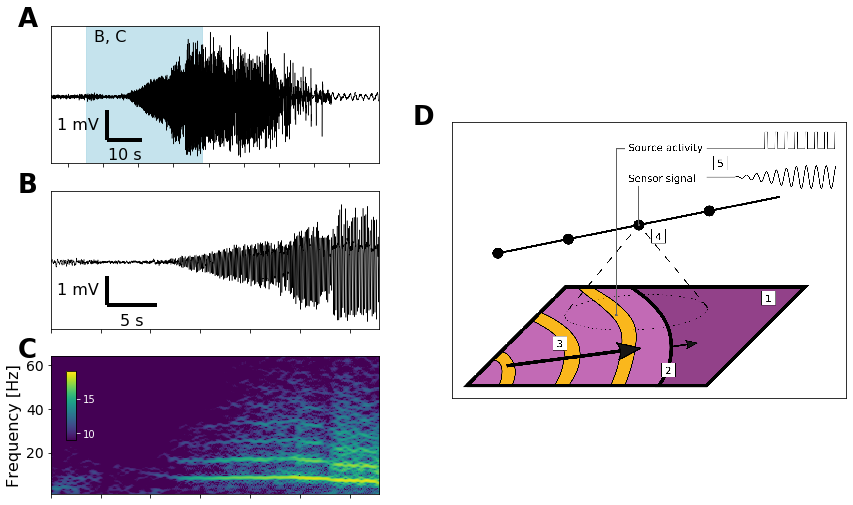

In [14]:
fig = plt.figure(figsize=(12, 7))

gs = GridSpec(3, 2, left=0.06, right=0.98, bottom=0.03, top=0.96, hspace=0.2, wspace=0.2, width_ratios=[1, 1.2])


ax0 = plt.subplot(gs[0, 0])

plt.plot(t, x, color='k', lw=0.5)
plt.xlim(sz_interval)
scale_bars(ax0, (0.17, 0.17), sizex=10, labelx="10 s", sizey=1000, labely="1 mV", fontsize=16)
plt.axvspan(taa_interval[0], taa_interval[1], color='lightblue', zorder=-1, alpha=0.7)
plt.text(0.13, 0.88, "B, C", fontsize=16, transform=ax0.transAxes)
# plt.xticks([]);
plt.yticks([])
ax0.xaxis.set_major_locator(plt.MultipleLocator(10))
ax0.set_xticklabels([])


ax1 = plt.subplot(gs[1, 0], sharey=ax0)
plt.plot(t, x, color='k', lw=0.5)
plt.xlim(taa_interval)
scale_bars(ax1, (0.17, 0.17), sizex=5, labelx="5 s", sizey=1000, labely="1 mV", fontsize=16)
# plt.xticks([]);
plt.yticks([])
ax1.xaxis.set_major_locator(plt.MultipleLocator(5))
ax1.set_xticklabels([])

ax2 = plt.subplot(gs[2, 0], sharex=ax1)
plt.imshow(np.log(tfr), origin='lower', aspect='auto', extent=[t[0], t[-1], freqs[0], freqs[-1]],
           vmin=9, vmax=19)
plt.xlim(taa_interval)
# plt.xlabel("Time", fontsize=16)
plt.ylabel("Frequency [Hz]", fontsize=16)
plt.tick_params(axis='both', labelsize=14)


cbaxes = inset_axes(ax2, width="3%", height="50%", loc=2, borderpad=1.5)
cb = plt.colorbar(cax=cbaxes, orientation='vertical')
cb.ax.tick_params(color='w', labelcolor='w')


ax3 = plt.subplot(gs[0:3, 1])
im = plt.imread("../etc/taa.png")
plt.imshow(im, interpolation='none')
# plt.axis('off')
plt.xticks([])
plt.yticks([])


add_panel_letters(fig, axes=[ax0, ax1, ax2, ax3], fontsize=26, xpos=-0.1, ypos=0.99)
# plt.tight_layout()
plt.savefig("figs/taa-example.pdf")

# bg = Background(visible=True)